## Short Introduction

Understanding calorie burn during physical activities is crucial for fitness enthusiasts and health-conscious individuals. This project focuses on predicting the number of calories burned during a training session using data about the training specifics and the individual trainee. By leveraging machine learning techniques, the aim was to build a robust predictive model that can provide accurate insights into energy expenditure, helping users tailor their workouts and nutrition plans effectively.

The best result was achieved using **CatBoost Algorithm**:

- **RMSE: 9.79**

- **MAE: 7.40**

- **MAPE: 0.88%**

- **$R^2$ : 0.9989**

## Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from matplotlib.colors import LinearSegmentedColormap
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from scipy.stats import uniform, randint
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import VotingRegressor, StackingRegressor
import joblib

In [2]:
df = pd.read_csv("/kaggle/input/gym-members-exercise-dataset/gym_members_exercise_tracking.csv")
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


## Train/Test Split

In [3]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

## Exploratory Data Analysis

In [4]:
gym = train_set.copy()

In [5]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
Index: 778 entries, 967 to 102
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            778 non-null    int64  
 1   Gender                         778 non-null    object 
 2   Weight (kg)                    778 non-null    float64
 3   Height (m)                     778 non-null    float64
 4   Max_BPM                        778 non-null    int64  
 5   Avg_BPM                        778 non-null    int64  
 6   Resting_BPM                    778 non-null    int64  
 7   Session_Duration (hours)       778 non-null    float64
 8   Calories_Burned                778 non-null    float64
 9   Workout_Type                   778 non-null    object 
 10  Fat_Percentage                 778 non-null    float64
 11  Water_Intake (liters)          778 non-null    float64
 12  Workout_Frequency (days/week)  778 non-null    int64 

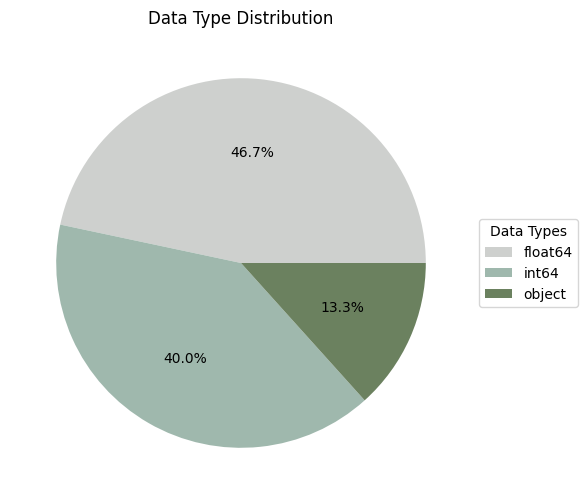

In [6]:
def plot_dtype_distribution(df):

    dtype_counts = df.dtypes.value_counts()

    total_columns = len(df.columns)
    dtype_percentages = (dtype_counts / total_columns) * 100

    colors = ["#CED0CE", "#9FB8AD", "#6B815F"]
    
    plt.figure(figsize=(8,6))
    wedges, texts, autotexts = plt.pie(dtype_percentages, colors = colors, autopct="%.1f%%", startangle=0)
    plt.legend(wedges, dtype_counts.index, title="Data Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title("Data Type Distribution")
    plt.show()

plot_dtype_distribution(gym)

In [7]:
def plot_missing_values(df):

    missing_percentages = (df.isnull().sum() / len(df)) * 100
    missing_percentages = missing_percentages[missing_percentages > 0]

    if not missing_percentages.empty:
        plt.figure(figsize=(10,6))
        missing_percentages.sort_values().plot(kind = "bar", color = "#9FB8AD")
        plt.xlabel("Columns")
        plt.ylabel("% of missing values")
        plt.title("Percentage of Missing Values in Each Column")
        plt.xticks(rotation=45, ha = "right")
        plt.tight_layout()
        plt.show()

    else:
        print("No columns with missing values!")

plot_missing_values(gym)

No columns with missing values!


In [8]:
def show_column_info(df):

    column_info = {
        "Column": [],
        "Data Type": [],
        "Unique Values": []
    }

    for column in df.columns:
        column_info["Column"].append(column)
        column_info["Data Type"].append(df[column].dtype)
        column_info["Unique Values"].append(df[column].nunique())

    column_info_df = pd.DataFrame(column_info)
    return print(column_info_df)

show_column_info(gym)

                           Column Data Type  Unique Values
0                             Age     int64             42
1                          Gender    object              2
2                     Weight (kg)   float64            471
3                      Height (m)   float64             51
4                         Max_BPM     int64             40
5                         Avg_BPM     int64             50
6                     Resting_BPM     int64             25
7        Session_Duration (hours)   float64            143
8                 Calories_Burned   float64            531
9                    Workout_Type    object              4
10                 Fat_Percentage   float64            227
11          Water_Intake (liters)   float64             23
12  Workout_Frequency (days/week)     int64              4
13               Experience_Level     int64              3
14                            BMI   float64            633


In [9]:
def show_frequent_values(df, threshold):
    for column in df.columns:
        value_counts = df[column].value_counts(normalize=True) * 100
        frequent_values = value_counts[value_counts >= threshold]

        if not frequent_values.empty:
            print(frequent_values)
            print()

show_frequent_values(gym, 15)

Gender
Male      53.213368
Female    46.786632
Name: proportion, dtype: float64

Workout_Type
Strength    27.120823
Cardio      26.863753
Yoga        23.007712
HIIT        23.007712
Name: proportion, dtype: float64

Workout_Frequency (days/week)
3    39.331620
4    31.362468
2    18.894602
Name: proportion, dtype: float64

Experience_Level
2    42.544987
1    38.303342
3    19.151671
Name: proportion, dtype: float64



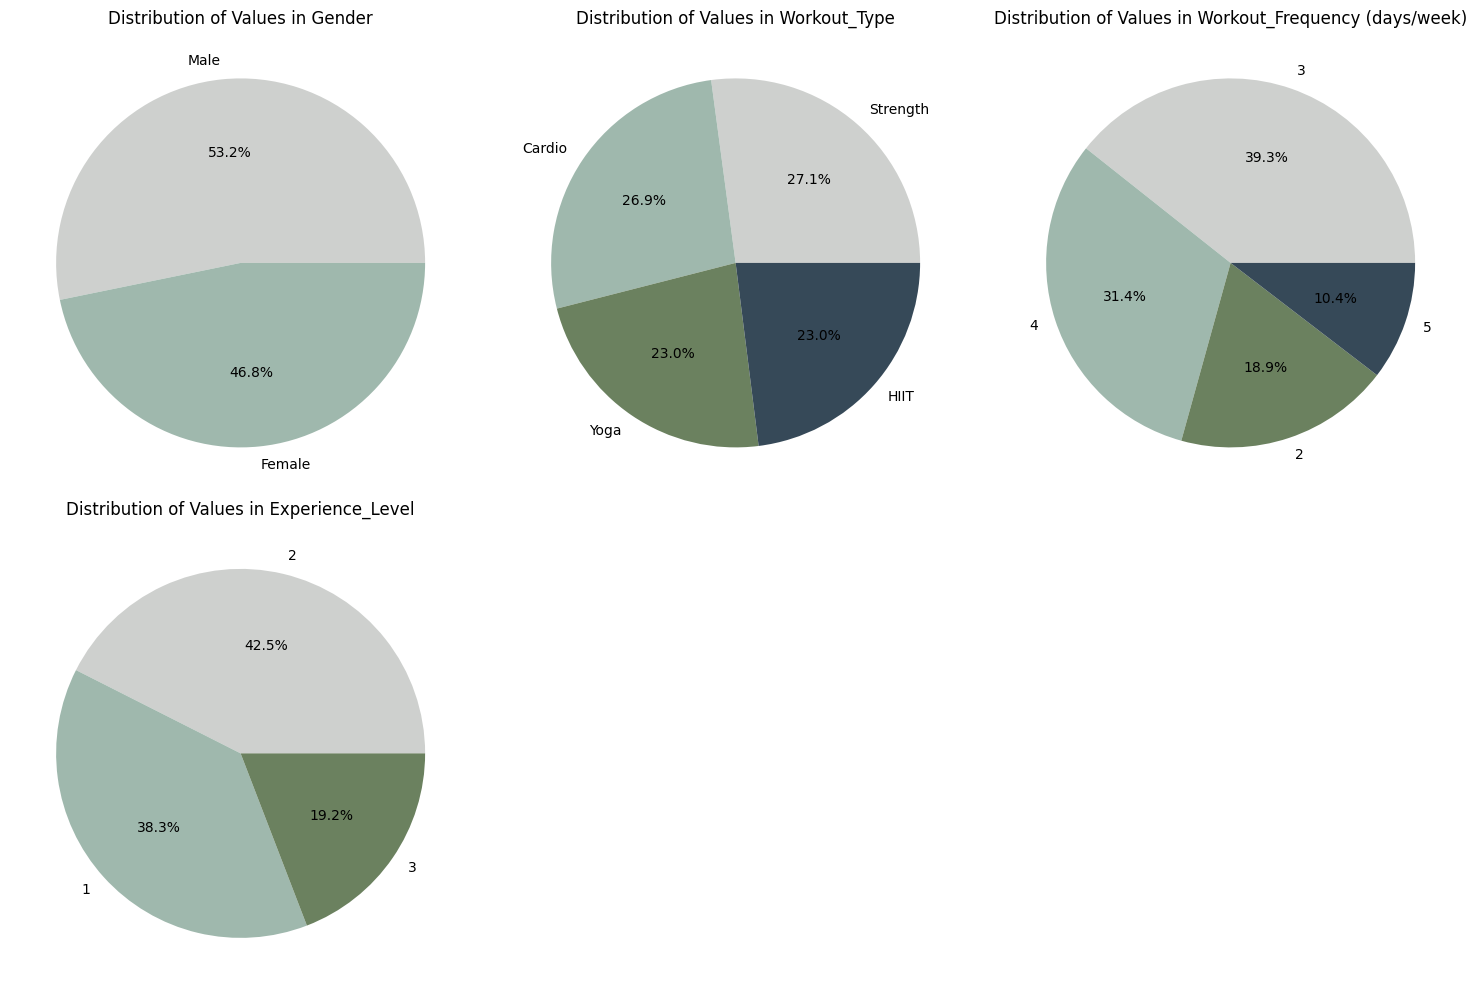

In [10]:
def pie_chart_of_columns(df, max_unique_values):
    
    columns_to_plot = [column for column in df.columns if df[column].nunique() < max_unique_values]

    num_plots = len(columns_to_plot)

    num_rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)

    plt.figure(figsize=(15, num_rows * 5))
    
    for idx, column in enumerate(columns_to_plot, 1):
        value_counts = df[column].value_counts(normalize=True) * 100

        plt.subplot(num_rows, 3, idx)
        plt.pie(value_counts, labels=value_counts.index, autopct="%.1f%%", startangle=0, 
                colors=["#CED0CE", "#9FB8AD", "#6B815F", "#364958", "#93748A"])
        plt.title(f"Distribution of Values in {column}")

    plt.tight_layout()
    plt.show()

pie_chart_of_columns(gym, 5)

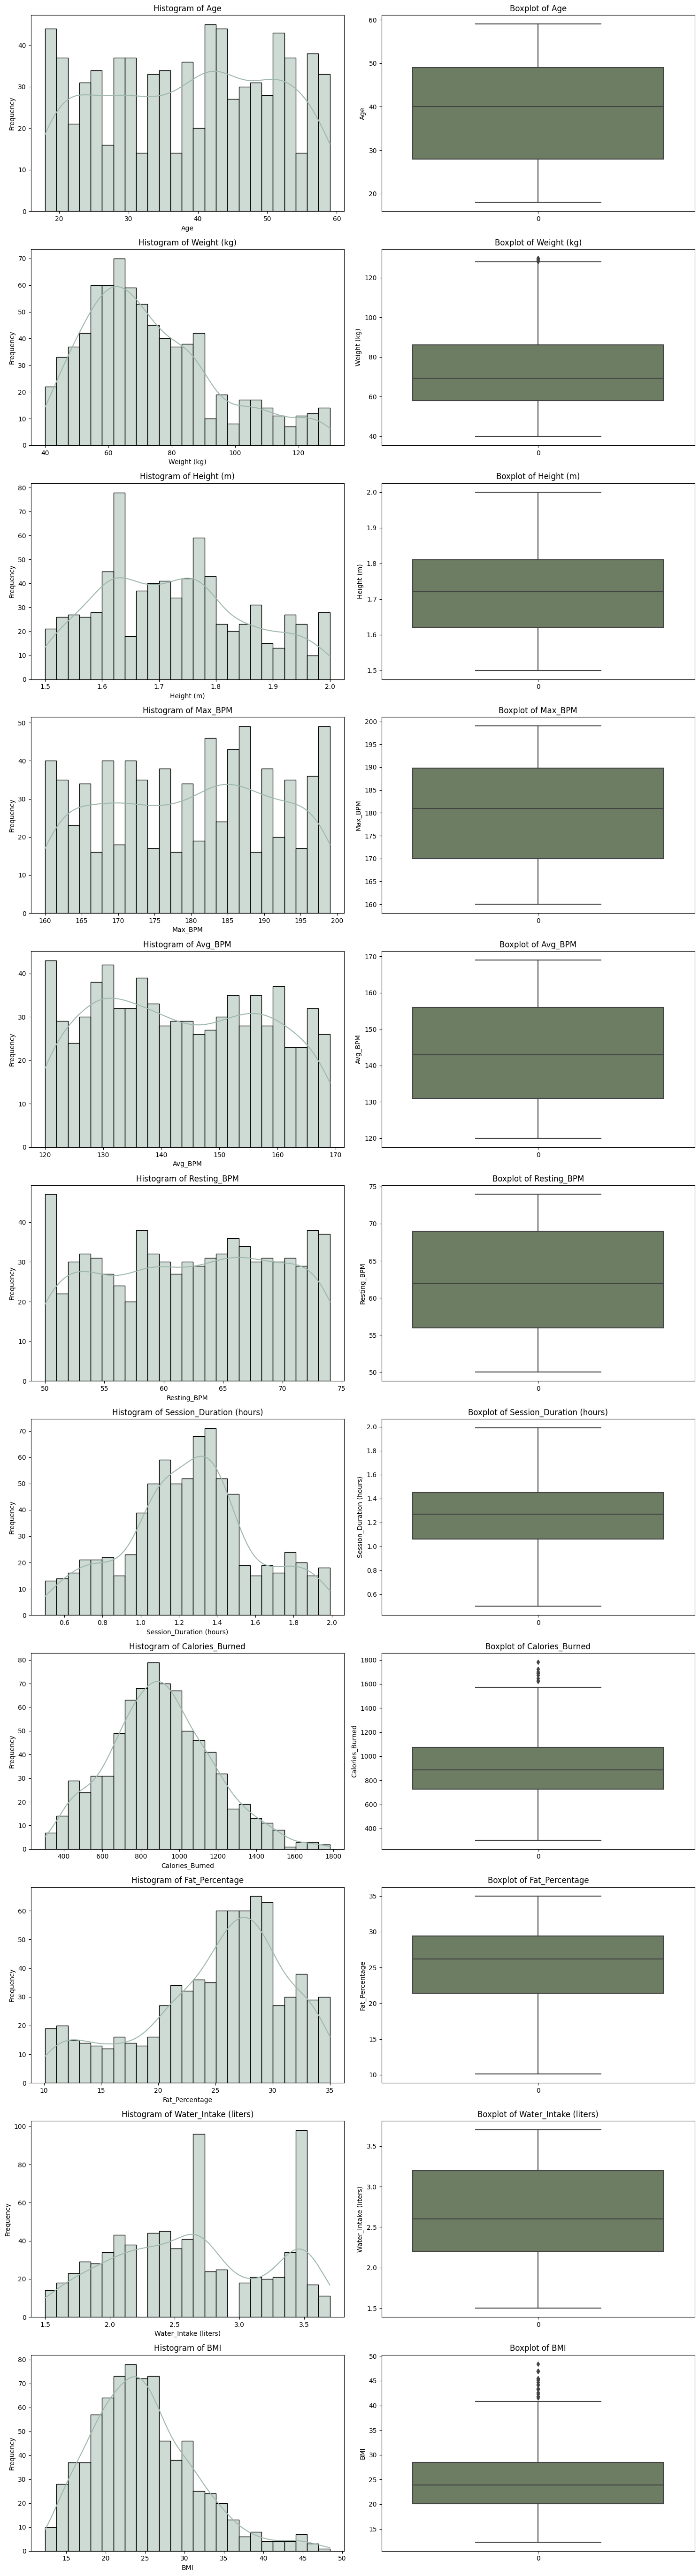

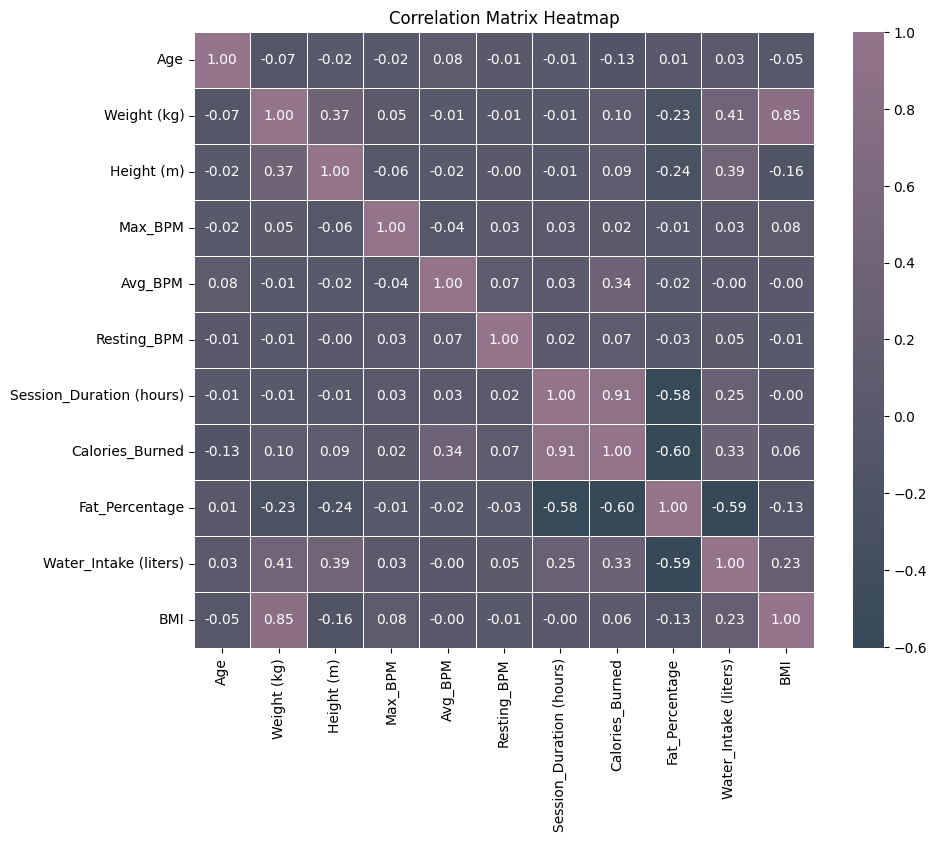

,count,mean,std,min,25%,50%,75%,max
Age,778.0,38.631105,12.160823,18.00,28.0000,40.00,49.0000,59.00
Weight (kg),778.0,73.583290,21.102063,40.00,58.0000,69.30,86.0250,129.90
Height (m),778.0,1.725129,0.129070,1.50,1.6200,1.72,1.8100,2.00
Max_BPM,778.0,179.863753,11.553332,160.00,170.0000,181.00,189.7500,199.00
Avg_BPM,778.0,143.520566,14.406320,120.00,131.0000,143.00,156.0000,169.00
Resting_BPM,778.0,62.204370,7.389382,50.00,56.0000,62.00,69.0000,74.00
Session_Duration (hours),778.0,1.255951,0.336939,0.50,1.0600,1.27,1.4500,1.99
Calories_Burned,778.0,904.024422,268.406314,303.00,725.5000,887.50,1073.7500,1783.00
Fat_Percentage,778.0,25.033419,6.249052,10.10,21.4000,26.20,29.4000,35.00
Water_Intake (liters),778.0,2.639846,0.601419,1.50,2.2000,2.60,3.2000,3.70


In [11]:
warnings.simplefilter(action='ignore', category=FutureWarning)

custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#364958", "#93748A"])

def analyze_filtered_data(df, min_unique_values, bins):
    
    filtered_columns = [column for column in df.columns if df[column].nunique() > min_unique_values]
    filtered_data = df[filtered_columns]

    
    num_columns = len(filtered_columns)
    plots_per_row = 2  

    fig, axes = plt.subplots(num_columns, plots_per_row, figsize=(15, 5 * num_columns))
    axes = axes.flatten()

    for idx, column in enumerate(filtered_columns):
        sns.histplot(filtered_data[column], bins= bins, kde=True, ax=axes[2 * idx], color="#9FB8AD")
        axes[2 * idx].set_title(f"Histogram of {column}")
        axes[2 * idx].set_xlabel(column)
        axes[2 * idx].set_ylabel("Frequency")

        sns.boxplot(data=filtered_data[column], ax=axes[2 * idx + 1], color="#6B815F")
        axes[2 * idx + 1].set_title(f"Boxplot of {column}")
        axes[2 * idx + 1].set_ylabel(column)

    for idx in range(num_columns * 2, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    corr_matrix = filtered_data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap=custom_cmap, fmt=".2f", cbar=True, linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()
    return filtered_data.describe().transpose()
    
    
analyze_filtered_data(gym, 5, 25)

## Data Preprocessing

In [12]:
X_train = gym.drop("Calories_Burned", axis=1)
y_train = gym["Calories_Burned"].copy()

In [13]:
def log_transform(X):
    return np.log(X + 1e-9)

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                             OneHotEncoder(drop="first", handle_unknown="ignore"))
log_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                             FunctionTransformer(log_transform, feature_names_out="one-to-one"),
                             StandardScaler())
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                                     StandardScaler())

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, make_column_selector(dtype_include = object)),
    ("log", log_pipeline, ["Weight (kg)", "Fat_Percentage", "BMI"]),
],
    remainder=default_num_pipeline)

In [14]:
X_prepared = preprocessing.fit_transform(X_train)

In [15]:
X_prepared.shape

(778, 16)

In [16]:
preprocessing.get_feature_names_out()

array(['cat__Gender_Male', 'cat__Workout_Type_HIIT',
       'cat__Workout_Type_Strength', 'cat__Workout_Type_Yoga',
       'log__Weight (kg)', 'log__Fat_Percentage', 'log__BMI',
       'remainder__Age', 'remainder__Height (m)', 'remainder__Max_BPM',
       'remainder__Avg_BPM', 'remainder__Resting_BPM',
       'remainder__Session_Duration (hours)',
       'remainder__Water_Intake (liters)',
       'remainder__Workout_Frequency (days/week)',
       'remainder__Experience_Level'], dtype=object)

## Model Selection

Evaluating Linear Regression...
Evaluating Ridge Regression...
Evaluating Lasso Regression...
Evaluating ElasticNet...
Evaluating Decision Tree Regressor...
Evaluating Random Forest Regressor...
Evaluating Gradient Boosting Regressor...
Evaluating Support Vector Regressor (SVR)...
Evaluating Bayesian Ridge Regression...
Evaluating XGBoost...
Evaluating LightGBM...
Evaluating CatBoost...


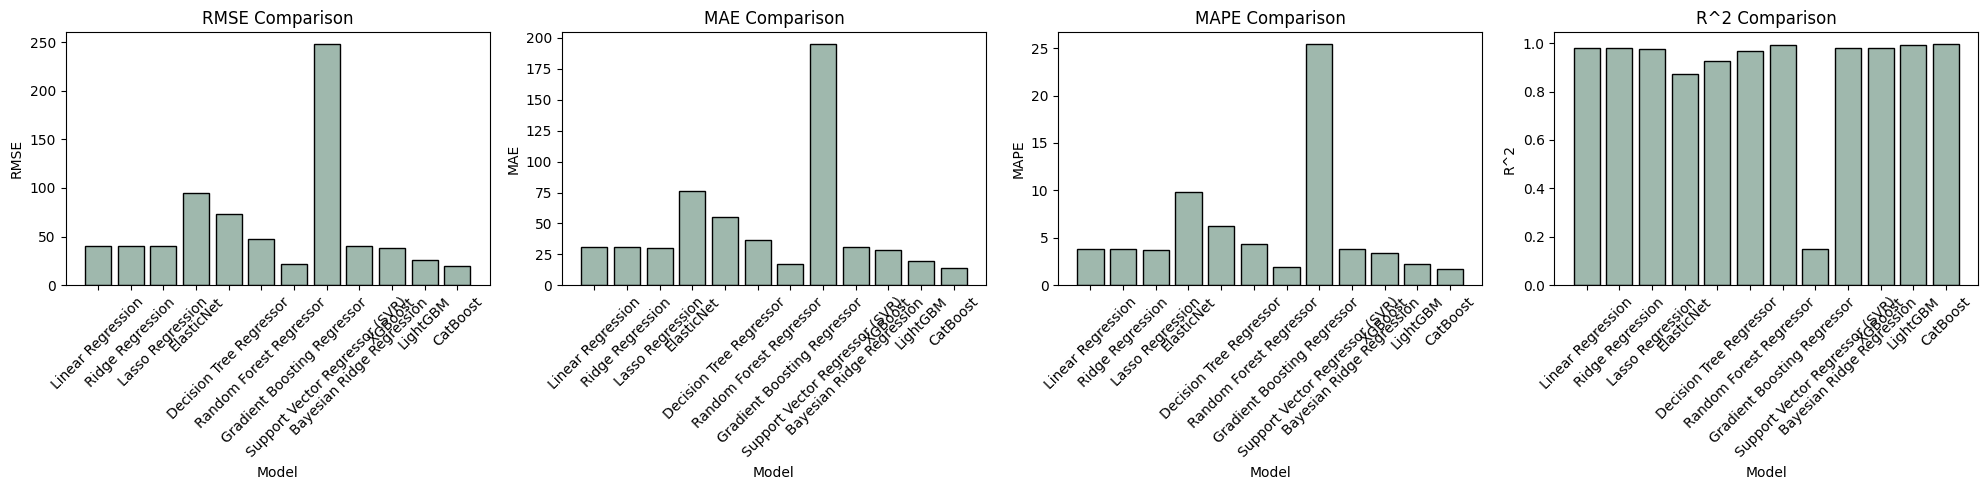

,Model,RMSE,MAE,MAPE,R^2,Time (s)
0,Linear Regression,40.129403,30.563919,3.800027,0.977618,0.183064
1,Ridge Regression,40.124130,30.540611,3.786663,0.977624,0.207208
2,Lasso Regression,40.169675,30.367892,3.718338,0.977573,0.171666
3,ElasticNet,95.161264,76.035235,9.788439,0.874138,0.125714
4,Decision Tree Regressor,73.419543,54.997429,6.286096,0.925080,0.152834
5,Random Forest Regressor,47.306412,36.969049,4.372370,0.968896,2.350190
6,Gradient Boosting Regressor,22.165524,16.994779,1.961525,0.993171,1.005610
7,Support Vector Regressor (SVR),247.585209,194.805994,25.392959,0.148034,0.244874
8,Bayesian Ridge Regression,40.117185,30.552509,3.795064,0.977632,0.279815
9,XGBoost,38.192429,28.355552,3.370326,0.979727,0.788820


In [17]:
def evaluate_models(preprocessing, X, y, models):
    
    results = {
        "Model": [],
        "RMSE": [],
        "MAE": [],
        "MAPE": [],
        "R^2": [],
        "Time (s)": []
    }

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
     
        pipeline = Pipeline([
            ("preprocessing", preprocessing),
            ("model", model)
        ])
        
        print(f"Evaluating {name}...")
        start_time = time.time()
        
        y_pred = cross_val_predict(pipeline, X, y, cv=kfold)
        
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mae = mean_absolute_error(y, y_pred)
        mape = np.mean(np.abs((y - y_pred) / y)) * 100
        r2 = r2_score(y, y_pred)
        
        elapsed_time = time.time() - start_time
        
        results["Model"].append(name)
        results["RMSE"].append(rmse)
        results["MAE"].append(mae)
        results["MAPE"].append(mape)
        results["R^2"].append(r2)
        results["Time (s)"].append(elapsed_time)

    metrics = ["RMSE", "MAE", "MAPE", "R^2"]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)
    
    for i, metric in enumerate(metrics):
        axes[i].bar(results["Model"], results[metric], color="#9FB8AD", edgecolor='black')
        axes[i].set_title(f"{metric} Comparison")
        axes[i].set_xlabel("Model")
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame(results)

    return results_df.head(15)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42),
    "ElasticNet": ElasticNet(random_state=42),
    
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    
    "Support Vector Regressor (SVR)": SVR(kernel='rbf'),
    
    "Bayesian Ridge Regression": BayesianRidge(),
    
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(learning_rate=0.1, iterations=500, depth=6, random_state=42, verbose=0)
}

evaluate_models(preprocessing, X_train, y_train, models)

## Model Hyperparameters Tuning

### n_iter=10

In [18]:
models = {
    "Bayesian Ridge": Pipeline([
        ("preprocessing", preprocessing), 
        ("bayesian_ridge", BayesianRidge()),
    ]),
    "Gradient Boosting": Pipeline([
        ("preprocessing", preprocessing),
        ("grad_boost", GradientBoostingRegressor(random_state=42)),
    ]),
    "XGBoost": Pipeline([
        ("preprocessing", preprocessing),
        ("xgb", XGBRegressor(random_state=42, use_label_encoder=False)),
    ]),
    "LightGBM": Pipeline([
        ("preprocessing", preprocessing),
        ("lgbm", LGBMRegressor(random_state=42, verbose=-1)),
    ]),
    "CatBoost": Pipeline([
        ("preprocessing", preprocessing),
        ("catboost", CatBoostRegressor(random_state=42, verbose=0)),
    ])
}

param_distributions = {
    "XGBoost": {
        "xgb__learning_rate": uniform(0.01, 0.3),
        "xgb__n_estimators": randint(50, 500),
        "xgb__max_depth": randint(3, 10),
        "xgb__subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "xgb__colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "xgb__gamma": uniform(0, 5),
        "xgb__reg_alpha": uniform(1e-4, 1),
        "xgb__reg_lambda": uniform(1e-4, 1)
    },
    "Gradient Boosting": {
        "grad_boost__learning_rate": uniform(0.01, 0.2),
        "grad_boost__n_estimators": randint(50, 500),
        "grad_boost__max_depth": randint(3, 10),
        "grad_boost__subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "grad_boost__min_samples_split": randint(2, 20),
        "grad_boost__min_samples_leaf": randint(1, 20),
        "grad_boost__max_features": ["sqrt", "log2", None]
    },
    "Bayesian Ridge": {
        "bayesian_ridge__alpha_1": uniform(1e-6, 1e-2),
        "bayesian_ridge__alpha_2": uniform(1e-6, 1e-2),
        "bayesian_ridge__lambda_1": uniform(1e-6, 1e-2),
        "bayesian_ridge__lambda_2": uniform(1e-6, 1e-2)
    },
    "LightGBM": {
        "lgbm__learning_rate": uniform(0.01, 0.3),
        "lgbm__n_estimators": randint(50, 500),
        "lgbm__max_depth": randint(3, 10),
        "lgbm__subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "lgbm__colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "lgbm__reg_alpha": uniform(1e-4, 1),
        "lgbm__reg_lambda": uniform(1e-4, 1)
    },
    "CatBoost": {
        "catboost__learning_rate": uniform(0.01, 0.3),
        "catboost__iterations": randint(50, 500),
        "catboost__depth": randint(3, 10),
        "catboost__subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "catboost__l2_leaf_reg": uniform(1e-4, 1)
    }
}

best_models = {}

for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    start_time = time.time()
    rnd_search = RandomizedSearchCV(model, param_distributions=param_distributions[name], 
                                    n_iter=10, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=5,
                                    random_state=42)
    rnd_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    
    best_models[name] = rnd_search.best_estimator_
    print(f"Best parameters for {name}: {rnd_search.best_params_}\n")
    print(f"Best RMSE Score for {name}: {-rnd_search.best_score_:.4f}\n")
    print(f"Elapsed Time for {name}: {elapsed_time:.4f}\n")

Tuning hyperparameters for Bayesian Ridge...
Best parameters for Bayesian Ridge: {'bayesian_ridge__alpha_1': 0.0006515159298527952, 'bayesian_ridge__alpha_2': 0.009489855372533332, 'bayesian_ridge__lambda_1': 0.009657320330745593, 'bayesian_ridge__lambda_2': 0.00808497348116461}

Best RMSE Score for Bayesian Ridge: 39.9827

Elapsed Time for Bayesian Ridge: 3.9353

Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'grad_boost__learning_rate': 0.0849080237694725, 'grad_boost__max_depth': 7, 'grad_boost__max_features': None, 'grad_boost__min_samples_leaf': 11, 'grad_boost__min_samples_split': 9, 'grad_boost__n_estimators': 238, 'grad_boost__subsample': 0.5}

Best RMSE Score for Gradient Boosting: 20.6912

Elapsed Time for Gradient Boosting: 17.4445

Tuning hyperparameters for XGBoost...
Best parameters for XGBoost: {'xgb__colsample_bytree': 0.3, 'xgb__gamma': 1.9123099563358137, 'xgb__learning_rate': 0.3049692657420365, 'xgb__max_depth': 3, 'xgb__n_es

In [19]:
def evaluate_models(X, y, models):
    results = {
        "Model": [],
        "RMSE": [],
        "MAE": [],
        "MAPE": [],
        "R^2": [],
        "Time (s)": []
    }

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        
        print(f"Evaluating {name}...")
        start_time = time.time()
        
        y_pred = cross_val_predict(model, X, y, cv=kfold)
        
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mae = mean_absolute_error(y, y_pred)
        mape = np.mean(np.abs((y - y_pred) / y)) * 100
        r2 = r2_score(y, y_pred)
        
        elapsed_time = time.time() - start_time
        
        results["Model"].append(name)
        results["RMSE"].append(rmse)
        results["MAE"].append(mae)
        results["MAPE"].append(mape)
        results["R^2"].append(r2)
        results["Time (s)"].append(elapsed_time)

    metrics = ["RMSE", "MAE", "MAPE", "R^2"]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)
    
    for i, metric in enumerate(metrics):
        axes[i].bar(results["Model"], results[metric], color="#9FB8AD", edgecolor='black')
        axes[i].set_title(f"{metric} Comparison")
        axes[i].set_xlabel("Model")
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    results_df = pd.DataFrame(results)

    return results_df.head(15)

Evaluating Bayesian Ridge...
Evaluating Gradient Boosting...
Evaluating XGBoost...
Evaluating LightGBM...
Evaluating CatBoost...


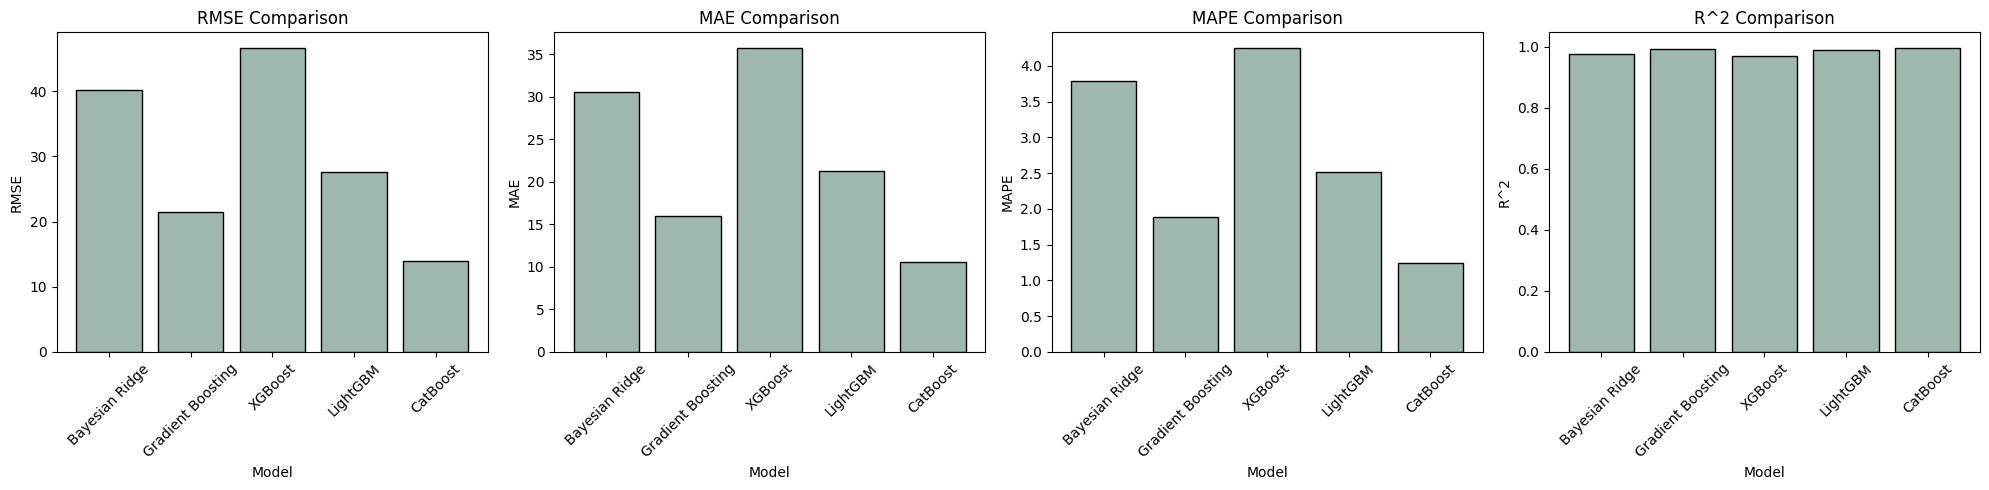

,Model,RMSE,MAE,MAPE,R^2,Time (s)
0,Bayesian Ridge,40.117185,30.552499,3.795059,0.977632,0.490249
1,Gradient Boosting,21.518073,15.987404,1.890864,0.993565,2.451876
2,XGBoost,46.698595,35.776190,4.256962,0.969690,0.366995
3,LightGBM,27.640621,21.298692,2.523187,0.989381,0.564806
4,CatBoost,13.911218,10.543281,1.238167,0.997310,1.055812


In [20]:
evaluate_models(X_train, y_train, best_models)

### n_iter=100

In [21]:
models = {
    "Bayesian Ridge": Pipeline([
        ("preprocessing", preprocessing), 
        ("bayesian_ridge", BayesianRidge()),
    ]),
    "Gradient Boosting": Pipeline([
        ("preprocessing", preprocessing),
        ("grad_boost", GradientBoostingRegressor(random_state=42)),
    ]),
    "XGBoost": Pipeline([
        ("preprocessing", preprocessing),
        ("xgb", XGBRegressor(random_state=42, use_label_encoder=False)),
    ]),
    "LightGBM": Pipeline([
        ("preprocessing", preprocessing),
        ("lgbm", LGBMRegressor(random_state=42, verbose=-1)),
    ]),
    "CatBoost": Pipeline([
        ("preprocessing", preprocessing),
        ("catboost", CatBoostRegressor(random_state=42, verbose=0)),
    ])
}

param_distributions = {
    "XGBoost": {
        "xgb__learning_rate": uniform(0.01, 0.3),
        "xgb__n_estimators": randint(50, 500),
        "xgb__max_depth": randint(3, 10),
        "xgb__subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "xgb__colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "xgb__gamma": uniform(0, 5),
        "xgb__reg_alpha": uniform(1e-4, 1),
        "xgb__reg_lambda": uniform(1e-4, 1)
    },
    "Gradient Boosting": {
        "grad_boost__learning_rate": uniform(0.01, 0.2),
        "grad_boost__n_estimators": randint(50, 500),
        "grad_boost__max_depth": randint(3, 10),
        "grad_boost__subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "grad_boost__min_samples_split": randint(2, 20),
        "grad_boost__min_samples_leaf": randint(1, 20),
        "grad_boost__max_features": ["sqrt", "log2", None]
    },
    "Bayesian Ridge": {
        "bayesian_ridge__alpha_1": uniform(1e-6, 1e-2),
        "bayesian_ridge__alpha_2": uniform(1e-6, 1e-2),
        "bayesian_ridge__lambda_1": uniform(1e-6, 1e-2),
        "bayesian_ridge__lambda_2": uniform(1e-6, 1e-2)
    },
    "LightGBM": {
        "lgbm__learning_rate": uniform(0.01, 0.3),
        "lgbm__n_estimators": randint(50, 500),
        "lgbm__max_depth": randint(3, 10),
        "lgbm__subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "lgbm__colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "lgbm__reg_alpha": uniform(1e-4, 1),
        "lgbm__reg_lambda": uniform(1e-4, 1)
    },
    "CatBoost": {
        "catboost__learning_rate": uniform(0.01, 0.3),
        "catboost__iterations": randint(50, 500),
        "catboost__depth": randint(3, 10),
        "catboost__subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "catboost__l2_leaf_reg": uniform(1e-4, 1)
    }
}

best_models = {}

for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    start_time = time.time()
    rnd_search = RandomizedSearchCV(model, param_distributions=param_distributions[name], 
                                    n_iter=100, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=5,
                                    random_state=42)
    rnd_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    
    best_models[name] = rnd_search.best_estimator_
    print(f"Best parameters for {name}: {rnd_search.best_params_}\n")
    print(f"Best RMSE Score for {name}: {-rnd_search.best_score_:.4f}\n")
    print(f"Elapsed Time for {name}: {elapsed_time:.4f}\n")

Tuning hyperparameters for Bayesian Ridge...
Best parameters for Bayesian Ridge: {'bayesian_ridge__alpha_1': 0.001449948720912231, 'bayesian_ridge__alpha_2': 0.00489552760277563, 'bayesian_ridge__lambda_1': 0.009857504541106007, 'bayesian_ridge__lambda_2': 0.0024215527151150045}

Best RMSE Score for Bayesian Ridge: 39.9827

Elapsed Time for Bayesian Ridge: 42.6744

Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'grad_boost__learning_rate': 0.058411054302300085, 'grad_boost__max_depth': 6, 'grad_boost__max_features': None, 'grad_boost__min_samples_leaf': 11, 'grad_boost__min_samples_split': 18, 'grad_boost__n_estimators': 304, 'grad_boost__subsample': 0.6}

Best RMSE Score for Gradient Boosting: 20.2768

Elapsed Time for Gradient Boosting: 159.0190

Tuning hyperparameters for XGBoost...
Best parameters for XGBoost: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 2.491238489244701, 'xgb__learning_rate': 0.1091045443842742, 'xgb__max_depth': 3, 'xgb__

Evaluating Bayesian Ridge...
Evaluating Gradient Boosting...
Evaluating XGBoost...
Evaluating LightGBM...
Evaluating CatBoost...


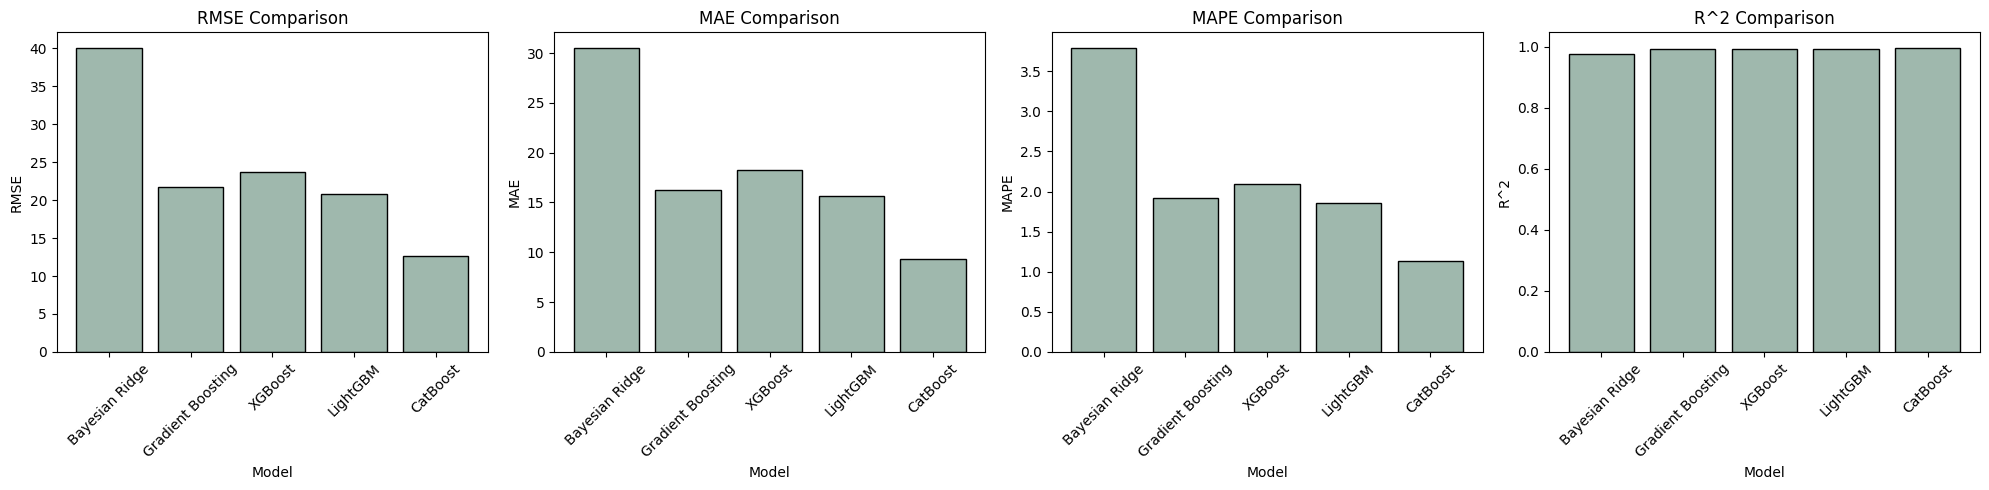

,Model,RMSE,MAE,MAPE,R^2,Time (s)
0,Bayesian Ridge,40.117185,30.552499,3.795059,0.977632,0.429303
1,Gradient Boosting,21.741742,16.288339,1.914954,0.993430,3.290416
2,XGBoost,23.760962,18.293497,2.092708,0.992153,0.697550
3,LightGBM,20.843476,15.666521,1.851736,0.993962,0.488162
4,CatBoost,12.660969,9.374270,1.132517,0.997772,1.172776


In [22]:
evaluate_models(X_train, y_train, best_models)

## Ensembles

In [23]:
voting_regressor = VotingRegressor(
    estimators=[
        ("light_gbm", best_models["LightGBM"]),
        ("cat_boost", best_models["CatBoost"]),
        ("gradient_boosting", best_models["Gradient Boosting"]),
        ("xgb", best_models["XGBoost"]),
    ]
)

stacking_regressor = StackingRegressor(
    estimators=[
        ("light_gbm", best_models["LightGBM"]), 
        ("cat_boost", best_models["CatBoost"]),
        ("gradient_boosting", best_models["Gradient Boosting"]),
        ("xgb", best_models["XGBoost"]),
    ],
    final_estimator=RandomForestRegressor(random_state=42),
    cv=5
)

In [24]:
models1 = {
    "Voting Regressor": voting_regressor,
    "Stacking Regressor": stacking_regressor
}

Evaluating Voting Regressor...
Evaluating Stacking Regressor...


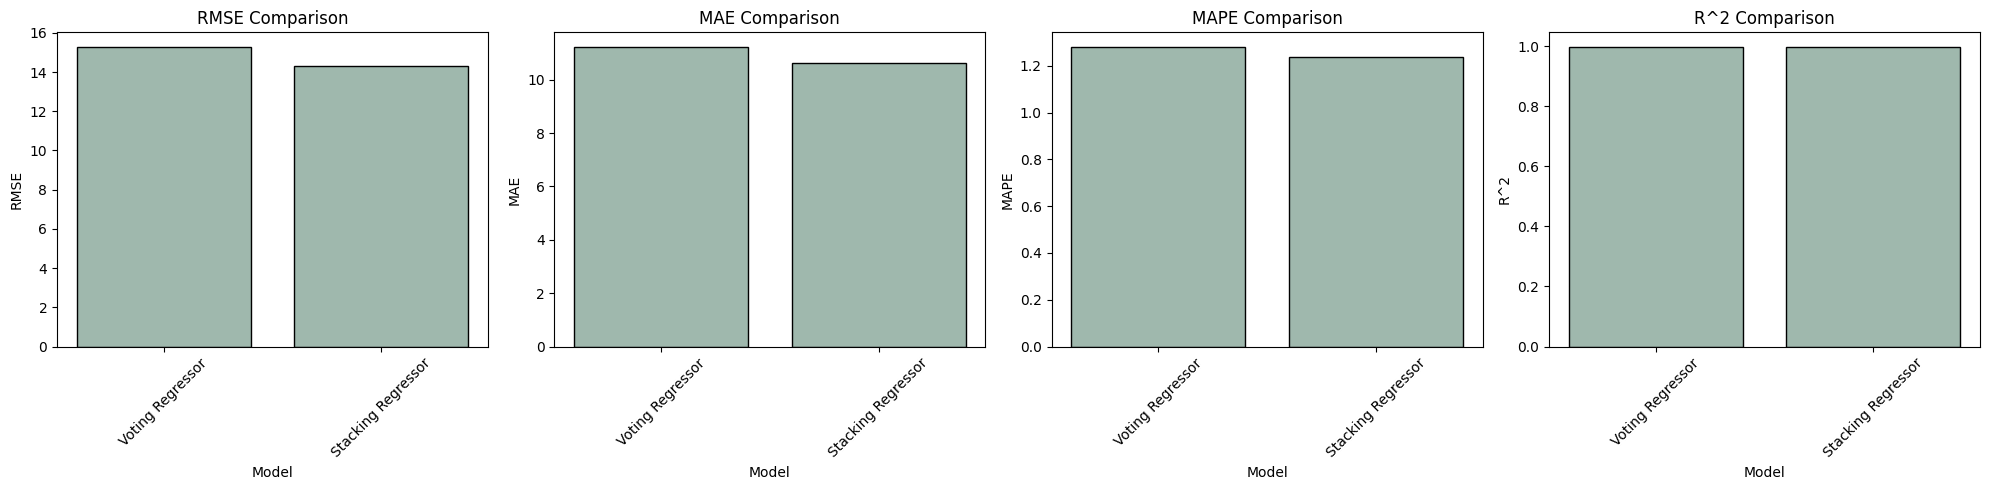

,Model,RMSE,MAE,MAPE,R^2,Time (s)
0,Voting Regressor,15.260926,11.213314,1.279734,0.996763,5.593527
1,Stacking Regressor,14.292538,10.642622,1.238594,0.997161,31.501745


In [25]:
evaluate_models(X_train, y_train, models1)

## Again CatBoost Tuning

In [26]:
models = {
        "CatBoost": Pipeline([
        ("preprocessing", preprocessing),
        ("catboost", CatBoostRegressor(random_state=42, verbose=0)),
        ])
}

param_distributions = {
"CatBoost": {
    "catboost__learning_rate": uniform(0.05, 0.15),
    "catboost__iterations": randint(400, 500), 
    "catboost__depth": randint(2, 5),  
    "catboost__subsample": [0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79],  
    "catboost__l2_leaf_reg": uniform(0.6, 0.8)  
            }
}

best_models = {}

for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    start_time = time.time()
    rnd_search = RandomizedSearchCV(model, param_distributions=param_distributions[name], 
                                    n_iter=100, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=5,
                                    random_state=42)
    rnd_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    
    best_models[name] = rnd_search.best_estimator_
    print(f"Best parameters for {name}: {rnd_search.best_params_}\n")
    print(f"Best RMSE Score for {name}: {-rnd_search.best_score_:.4f}\n")
    print(f"Elapsed Time for {name}: {elapsed_time:.4f}\n")

Tuning hyperparameters for CatBoost...
Best parameters for CatBoost: {'catboost__depth': 3, 'catboost__iterations': 454, 'catboost__l2_leaf_reg': 0.8006884218773289, 'catboost__learning_rate': 0.07765005114970551, 'catboost__subsample': 0.77}

Best RMSE Score for CatBoost: 10.8166

Elapsed Time for CatBoost: 124.0657



In [27]:
models2 = {
    "CatBoost": best_models["CatBoost"]
}

Evaluating CatBoost...


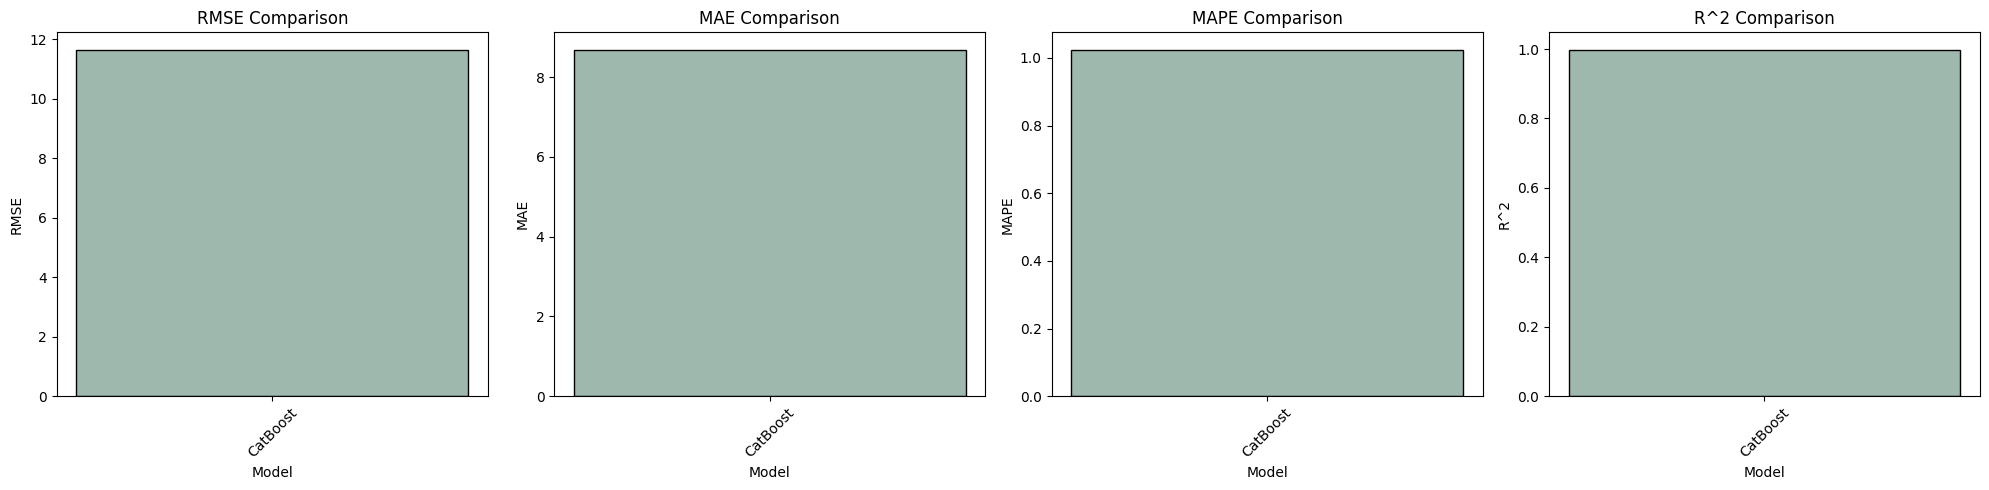

,Model,RMSE,MAE,MAPE,R^2,Time (s)
0,CatBoost,11.654352,8.687342,1.02447,0.998112,1.195705


In [28]:
evaluate_models(X_train, y_train, models2)

## Model Testing

In [29]:
X_test = test_set.drop("Calories_Burned", axis=1)
y_test = test_set["Calories_Burned"].copy()

In [30]:
final_models = {
    "Voting Regressor": voting_regressor,
    "Stacking Regressor": stacking_regressor,
    "CatBoost": best_models["CatBoost"],
}

Evaluating Voting Regressor...
Evaluating Stacking Regressor...
Evaluating CatBoost...


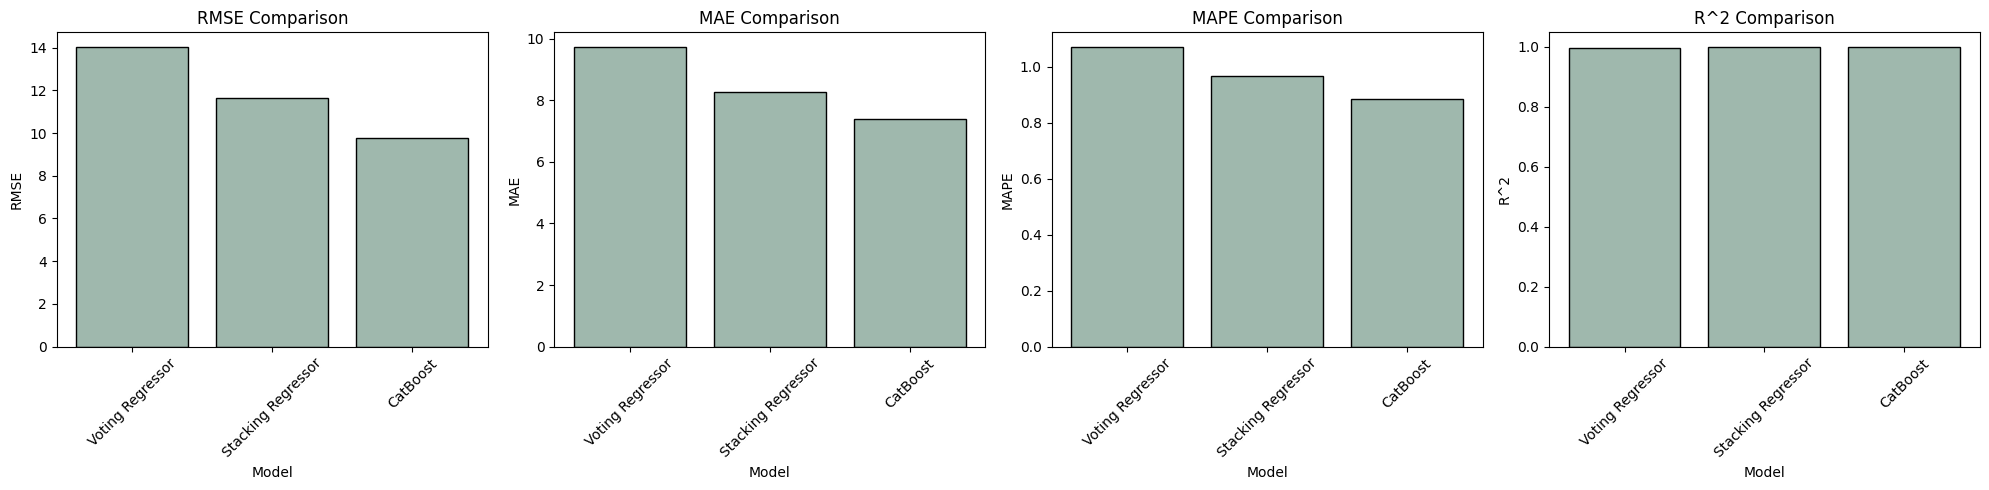

,Model,RMSE,MAE,MAPE,R^2,Time (s)
0,Voting Regressor,14.017964,9.729629,1.068768,0.997645,1.270290
1,Stacking Regressor,11.622866,8.283179,0.966308,0.998381,7.105974
2,CatBoost,9.788126,7.399240,0.883865,0.998852,0.252892


In [31]:
def evaluate_models(X_test, y_test, models):
    results = {
        "Model": [],
        "RMSE": [],
        "MAE": [],
        "MAPE": [],
        "R^2": [],
        "Time (s)": []
    }

    for name, model in models.items():
        
        print(f"Evaluating {name}...")
        start_time = time.time()
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        r2 = r2_score(y_test, y_pred)
        
        elapsed_time = time.time() - start_time
        
        results["Model"].append(name)
        results["RMSE"].append(rmse)
        results["MAE"].append(mae)
        results["MAPE"].append(mape)
        results["R^2"].append(r2)
        results["Time (s)"].append(elapsed_time)

    metrics = ["RMSE", "MAE", "MAPE", "R^2"]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)
    
    for i, metric in enumerate(metrics):
        axes[i].bar(results["Model"], results[metric], color="#9FB8AD", edgecolor='black')
        axes[i].set_title(f"{metric} Comparison")
        axes[i].set_xlabel("Model")
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    results_df = pd.DataFrame(results)

    return results_df.head(15)

evaluate_models(X_test, y_test, final_models)

In [32]:
for name, model in final_models.items():
    filename = f"{name.replace(' ', '_')}_model.pkl"
    joblib.dump(model, filename)
    print(f"Saved {name} model to {filename}")

Saved Voting Regressor model to Voting_Regressor_model.pkl
Saved Stacking Regressor model to Stacking_Regressor_model.pkl
Saved CatBoost model to CatBoost_model.pkl
